In [125]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=6)

import warnings
warnings.simplefilter(action='ignore')

#https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [126]:
# Read CSV
file_name1 = 'stroke.csv'
stroke_df = pd.read_csv(file_name1)

# preview data
print(stroke_df.describe())

                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0

In [127]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


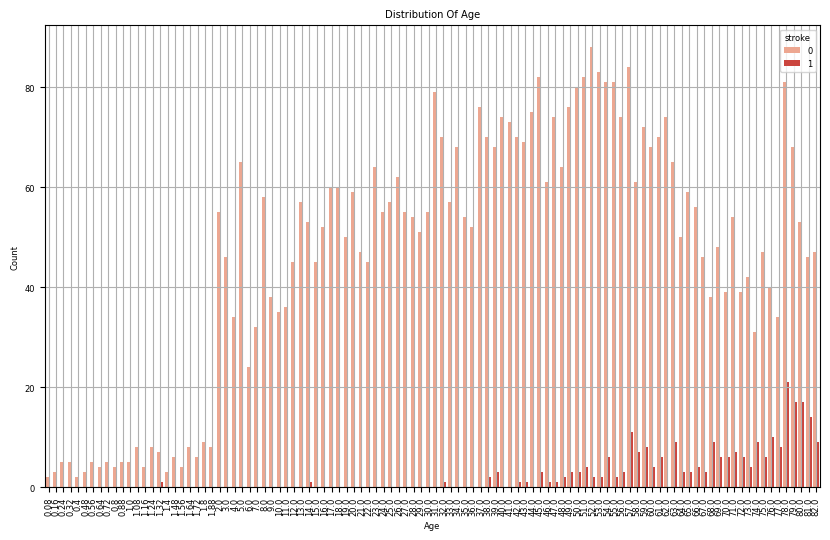

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='age', hue='stroke', data=stroke_df, palette='Reds')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.title("Distribution Of Age")
plt.grid(True)
plt.show()


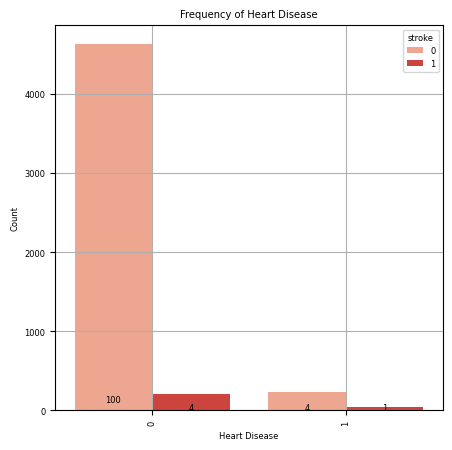

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 5))
ax = sns.countplot(x='heart_disease', hue='stroke', data=stroke_df, palette='Reds')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.title("Frequency of Heart Disease")
plt.grid(True)

for p in ax.patches:
    height = (p.get_height()/4632)*100
    ax.text(p.get_x() + p.get_width() / 2.,
            height+3,
            int(height),
            ha="center")

plt.show()


In [130]:
print(stroke_df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [131]:
(stroke_df['bmi'].isnull().sum()/len(stroke_df))*100

3.9334637964774952

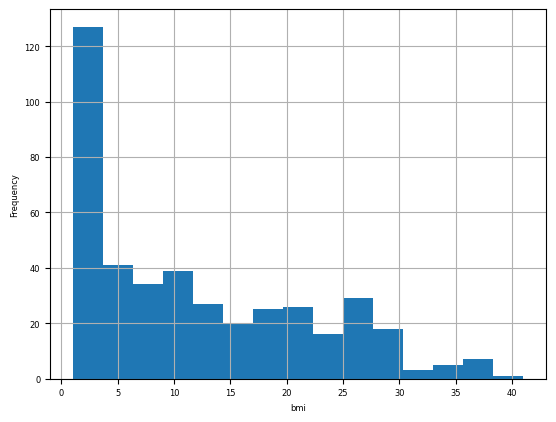

In [132]:
stroke_df['bmi'].value_counts().sort_index().plot.hist(bins = 15, rot = 0, grid = True)
plt.xlabel("bmi")
plt.ylabel("Frequency")
plt.show()

In [133]:
stroke_df['bmi'].mean()


28.893236911794673

In [134]:
stroke_df['bmi'].median()

28.1

In [135]:
(stroke_df['avg_glucose_level'].isnull().sum()/len(stroke_df))*100

0.0

In [136]:
stroke_df['avg_glucose_level'].value_counts().idxmax()

93.88

In [137]:
stroke_df2 = stroke_df.copy()

median2 = stroke_df['bmi'].median()
stroke_df2['bmi'].fillna(median2, inplace = True)

most = stroke_df['avg_glucose_level'].value_counts().idxmax()
stroke_df2['avg_glucose_level'].fillna(most, inplace = True)

In [138]:
stroke_df2.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [139]:
stroke_df2.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


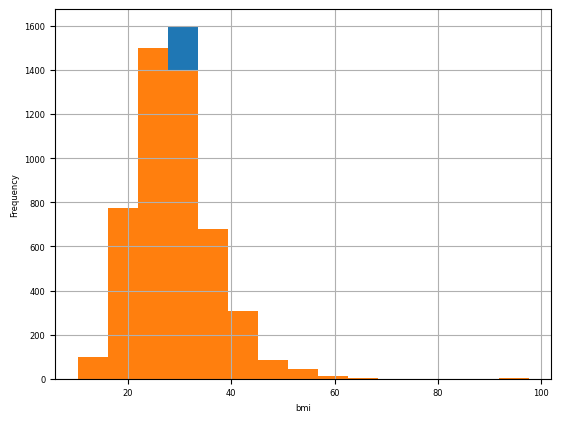

In [140]:
stroke_df2['bmi'].plot.hist(bins = 15, grid = True)
stroke_df['bmi'].plot.hist(bins = 15, grid = True)
plt.xlabel("bmi")
plt.ylabel("Frequency")
plt.show()

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd

feature_columns = ['age']  # List of feature columns
target_column = ['stroke']   # Target column

X = stroke_df2[feature_columns]
y = stroke_df2[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)


In [142]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = log_reg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9393346379647749


In [143]:
correlation = stroke_df2['age'].corr(stroke_df['stroke'])
correlation

0.24525734617097447

In [144]:
correlation1 = stroke_df2['avg_glucose_level'].corr(stroke_df['stroke'])
correlation1

0.13194544082571005

In [145]:
correlation2 = stroke_df['bmi'].corr(stroke_df['stroke'])
correlation2

0.04237366114923359

<AxesSubplot:>

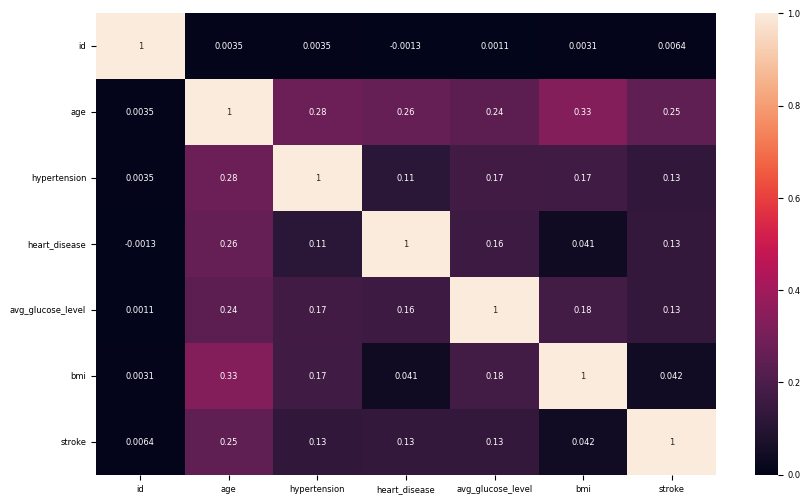

In [146]:
plt.figure(figsize=(10,6))
sns.heatmap(stroke_df.corr(),annot=True)

Epoch 1/50
123/123 - 1s - 12ms/step - accuracy: 0.9595 - loss: 0.2160 - val_accuracy: 0.9460 - val_loss: 0.1954
Epoch 2/50
123/123 - 0s - 2ms/step - accuracy: 0.9603 - loss: 0.1519 - val_accuracy: 0.9460 - val_loss: 0.1824
Epoch 3/50
123/123 - 0s - 2ms/step - accuracy: 0.9600 - loss: 0.1447 - val_accuracy: 0.9460 - val_loss: 0.1767
Epoch 4/50
123/123 - 1s - 5ms/step - accuracy: 0.9603 - loss: 0.1441 - val_accuracy: 0.9460 - val_loss: 0.1722
Epoch 5/50
123/123 - 0s - 2ms/step - accuracy: 0.9603 - loss: 0.1402 - val_accuracy: 0.9460 - val_loss: 0.1721
Epoch 6/50
123/123 - 0s - 2ms/step - accuracy: 0.9603 - loss: 0.1343 - val_accuracy: 0.9460 - val_loss: 0.1764
Epoch 7/50
123/123 - 0s - 2ms/step - accuracy: 0.9608 - loss: 0.1394 - val_accuracy: 0.9460 - val_loss: 0.1747
Epoch 8/50
123/123 - 0s - 2ms/step - accuracy: 0.9603 - loss: 0.1401 - val_accuracy: 0.9460 - val_loss: 0.1718
Epoch 9/50
123/123 - 0s - 2ms/step - accuracy: 0.9605 - loss: 0.1350 - val_accuracy: 0.9460 - val_loss: 0.1759


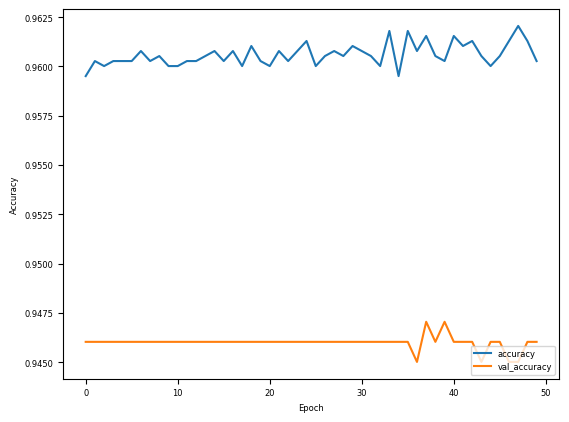

In [147]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

stroke_df.dropna(inplace=True)

label_encoders = {}
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    stroke_df[col] = label_encoders[col].fit_transform(stroke_df[col])

X = stroke_df.drop(columns=['stroke'])
y = stroke_df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.9460285132382892


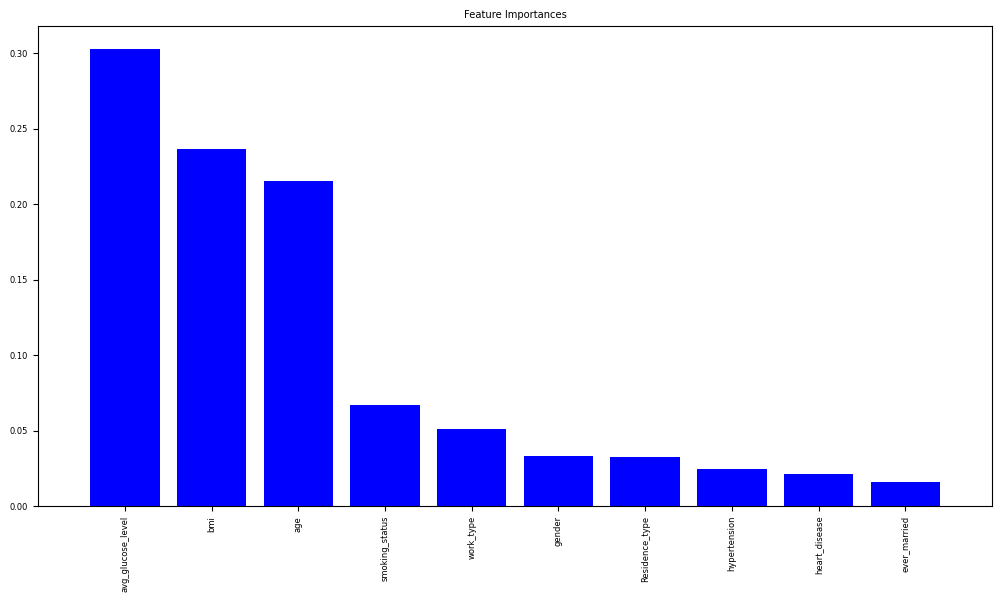

In [148]:

X = stroke_df.drop(columns=["id", "stroke"])
y = stroke_df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

feature_importances = rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

In [149]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Accuracy for neural network

stroke_df2.drop(columns=["id", "gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"], inplace=True)

X = stroke_df2[['age', 'avg_glucose_level', 'bmi']]
y = stroke_df2['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(100, activation='relu', input_shape=(3,)),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=50, batch_size=8, verbose=1)

loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9539 - loss: 0.2329
Epoch 2/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9496 - loss: 0.1676
Epoch 3/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9454 - loss: 0.1661
Epoch 4/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9515 - loss: 0.1590
Epoch 5/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9524 - loss: 0.1618
Epoch 6/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9548 - loss: 0.1551
Epoch 7/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9495 - loss: 0.1574
Epoch 8/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9552 - loss: 0.1503
Epoch 9/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9517 - loss: 0.1563
Epoch 10/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1515
Epoch 11/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9570 - loss: 0.1470
Epoch 12/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Epoch 1/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9390 - loss: 0.2523 - val_accuracy: 0.9393 - val_loss: 0.1938
Epoch 2/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9559 - loss: 0.1554 - val_accuracy: 0.9393 - val_loss: 0.1877
Epoch 3/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9571 - loss: 0.1440 - val_accuracy: 0.9393 - val_loss: 0.1837
Epoch 4/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9565 - loss: 0.1460 - val_accuracy: 0.9393 - val_loss: 0.1842
Epoch 5/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9569 - loss: 0.1510 - val_accuracy: 0.9393 - val_loss: 0.1882
Epoch 6/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9532 - loss: 0.1493 - val_accuracy: 0.9393 - val_loss: 0.1842
Epoch 7/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9575 - loss: 0.1454 - val_accuracy: 0.9393 - val_loss: 0.1882
Epoch 8/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9551 - loss: 0.1444 - val_accuracy: 0.

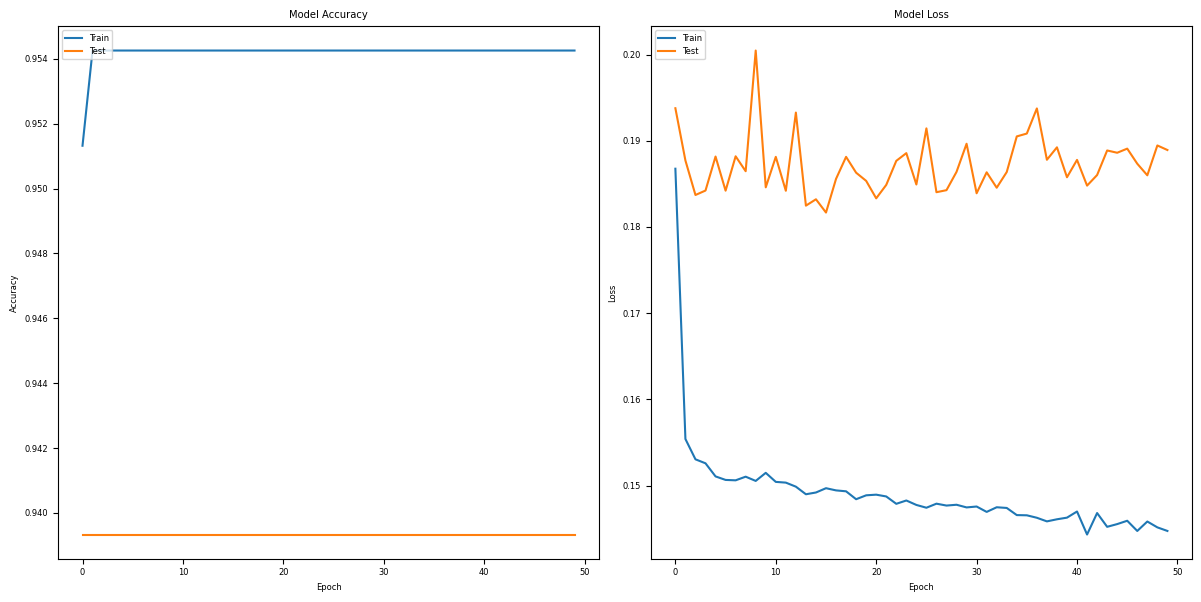

In [150]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
## Performance model for neural network 
model = Sequential([
    Dense(100, activation='relu', input_shape=(3,)),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=8, verbose=1, validation_data=(X_test_scaled, y_test))


loss, accuracy = model.evaluate(X_test_scaled, y_test)

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
## Accuracy for Random Forest
X = stroke_df2[['age', 'avg_glucose_level', 'bmi']]
y = stroke_df2['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 93.84%


In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
## Classification Report for Random Forest
features = ['age', 'avg_glucose_level', 'bmi']
X = stroke_df2[features]
y = stroke_df2['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.33      0.02      0.03        62

    accuracy                           0.94      1022
   macro avg       0.64      0.51      0.50      1022
weighted avg       0.90      0.94      0.91      1022



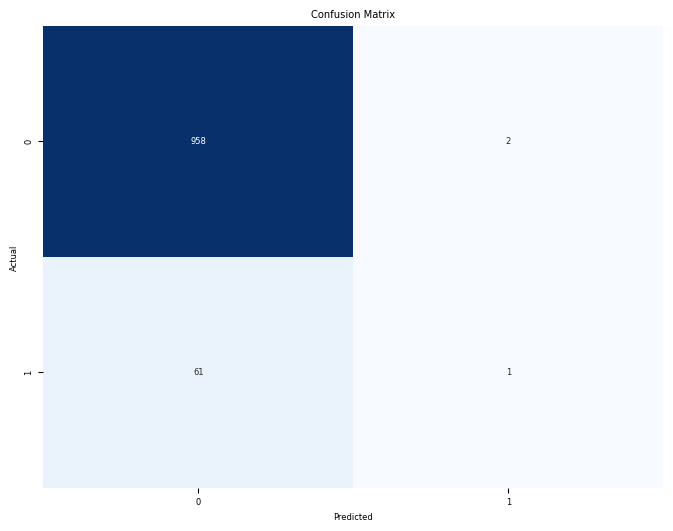

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

##Confusion Matrix
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

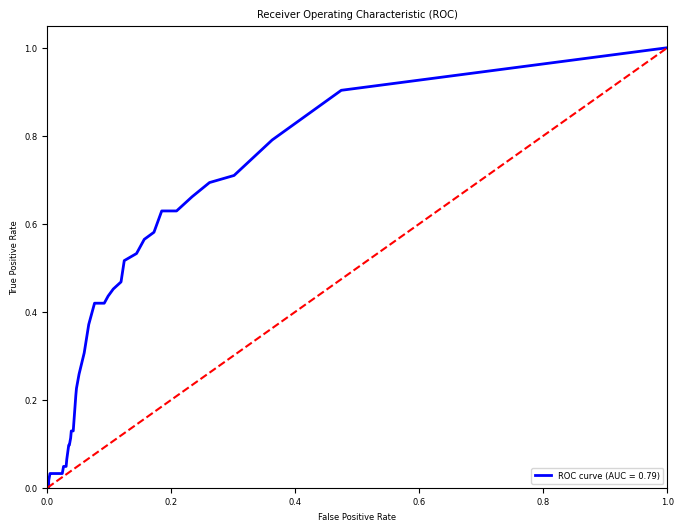

In [154]:
y_proba = rf_classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
## ROC model for Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

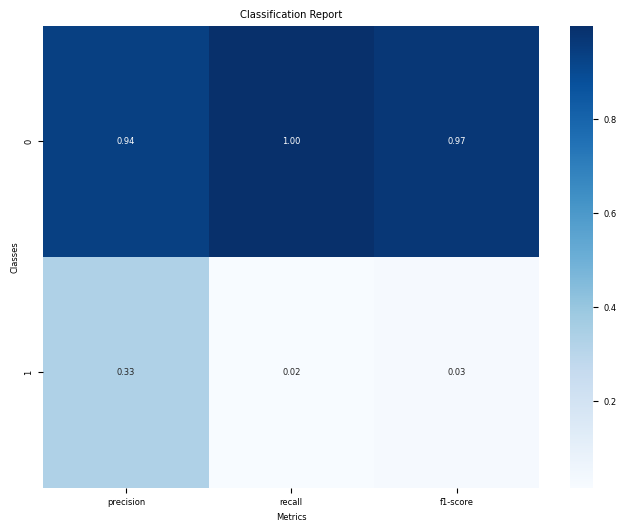

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
## Classification Report 
cr = classification_report(y_test, y_pred, output_dict=True)

class_labels = list(cr.keys())[:-3] 
metrics = ['precision', 'recall', 'f1-score']  

values = np.array([[cr[label][metric] for metric in metrics] for label in class_labels])

plt.figure(figsize=(8, 6))
sns.heatmap(values, annot=True, cmap="Blues", fmt='.2f', xticklabels=metrics, yticklabels=class_labels)
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()